In [1]:
%matplotlib inline

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


训练一个分类器
=====================

上一讲中已经看到如何去定义一个神经网络，计算损失值和更新网络的权重。
你现在可能在想下一步。


关于数据？
----------------

一般情况下处理图像、文本、音频和视频数据时，可以使用标准的Python包来加载数据到一个numpy数组中。
然后把这个数组转换成 ``torch.*Tensor``。

-  图像可以使用 Pillow, OpenCV
-  音频可以使用 scipy, librosa
-  文本可以使用原始Python和Cython来加载，或者使用 NLTK或
   SpaCy 处理

特别的，对于图像任务，我们创建了一个包
``torchvision``，它包含了处理一些基本图像数据集的方法。这些数据集包括
Imagenet, CIFAR10, MNIST 等。除了数据加载以外，``torchvision`` 还包含了图像转换器，
``torchvision.datasets`` 和 ``torch.utils.data.DataLoader``。

``torchvision``包不仅提供了巨大的便利，也避免了代码的重复。

在这个教程中，我们使用CIFAR10数据集，它有如下10个类别
：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10的图像都是
3x32x32大小的，即，3颜色通道，32x32像素。

![](https://pytorch.org/tutorials/_images/cifar10.png)


训练一个图像分类器
----------------------------

依次按照下列顺序进行：

1. 使用``torchvision``加载和归一化CIFAR10训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 在测试集上测试网络


1. 读取和归一化 CIFAR10
------------------------------

使用``torchvision``可以非常容易地加载CIFAR10。


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision的输出是[0,1]的PILImage图像，我们把它转换为归一化范围为[-1, 1]的张量。


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


我们展示一些训练图像。



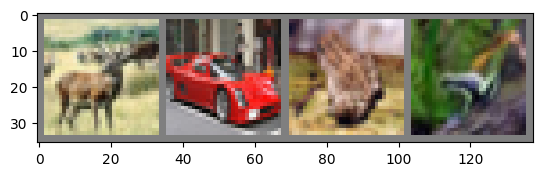

 deer   car  frog  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取随机数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


2. 定义一个卷积神经网络
-------------------------------
从之前的神经网络一节复制神经网络代码，并修改为输入3通道图像。


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


3. 定义损失函数和优化器
----------------------------------------

我们使用交叉熵作为损失函数，使用带动量的随机梯度下降。



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


4. 训练网路
--------------------------------
有趣的时刻开始了。
我们只需在数据迭代器上循环，将数据输入给网络，并优化。



In [7]:
for epoch in range(2):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.884
[1,  6000] loss: 1.677
[1,  8000] loss: 1.576
[1, 10000] loss: 1.511
[1, 12000] loss: 1.449
[2,  2000] loss: 1.389
[2,  4000] loss: 1.373
[2,  6000] loss: 1.340
[2,  8000] loss: 1.311
[2, 10000] loss: 1.313
[2, 12000] loss: 1.298
Finished Training


保存我们训练的模型

In [8]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)


5. 在测试集上测试网络
-------------------------------------

我们在整个训练集上进行了2次训练，但是我们需要检查网络是否从数据集中学习到有用的东西。    
通过预测神经网络输出的类别标签与实际情况标签进行对比来进行检测。    
如果预测正确，我们把该样本添加到正确预测列表。    
第一步，显示测试集中的图片并熟悉图片内容。



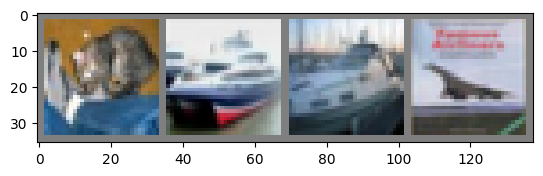

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，让我们加载之前保存的模型（注意：保存和重新加载模型在这里不是必要的，我们只是展示该如果操作）

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

让我们看看神经网络认为以上图片是什么。



In [11]:
outputs = net(images)

输出是10个标签的能量。
一个类别的能量数值越大，神经网络越认为它是这个类别。所以让我们得到最高能量的标签。

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


结果看来不错。

接下来让看看网络在整个测试集上的结果如何。

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
# 因为我们没有在训练，所以我们不需要计算output输出的梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        # 通过网络模型计算images的输出
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        # 我们选择能量最高的分类作为预测结果
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


结果看起来不错，至少比随机选择要好，随机选择的正确率为10%（在10个分类中随机选择1个）。
似乎网络学习到了一些东西。

嗯，表现良好的类别有哪些，表现不佳的类别又有哪些呢？

In [14]:
# prepare to count predictions for each class
# 准备为每一个分类的预测结果进行计数
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
# 同上，这里进行预测，不需要计算梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) # 网络模型预测images得到输出outputs
        _, predictions = torch.max(outputs, 1) # 使用最高能量的分类作为预测结果

        # collect the correct predictions for each class
        # 收集每个分类的正确预测结果
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
# 打印每个分类的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.0 %
Accuracy for class: car   is 48.5 %
Accuracy for class: bird  is 34.1 %
Accuracy for class: cat   is 30.2 %
Accuracy for class: deer  is 55.4 %
Accuracy for class: dog   is 56.7 %
Accuracy for class: frog  is 61.7 %
Accuracy for class: horse is 53.0 %
Accuracy for class: ship  is 51.0 %
Accuracy for class: truck is 75.8 %


下一步?

我们如何在GPU上运行神经网络呢？

在GPU上训练
----------------
把一个神经网络移动到GPU上训练就像把一个Tensor转换GPU上一样简单。

并且这个操作会递归遍历有所模块，并将其参数和缓冲区转换为CUDA张量。


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 确认我们的电脑支持CUDA，然后显示CUDA信息：

print(device)

cuda:0


本节的其余部分假定`device`是CUDA设备。

然后这些方法将递归遍历所有模块并将模块的参数和缓冲区
转换成CUDA张量：


```python

net.to(device)
```

记住：inputs, targets 和 images 也要转换。

```python

inputs, labels = inputs.to(device), labels.to(device)
```
为什么我们没注意到GPU的速度提升很多？那是因为网络非常的小。

**实践:** 
尝试增加你的网络的宽度（第一个``nn.Conv2d``的第2个参数，第二个``nn.Conv2d``的第一个参数，它们需要是相同的数字），看看你得到了什么样的加速。

**实现的目标**:

- 深入了解了PyTorch的张量库和神经网络
- 训练了一个小网络来分类图片

***译者注：后面我们教程会训练一个真正的网络，使识别率达到90%以上。***

多GPU训练
-------------------------
如果你想使用所有的GPU得到更大的加速，
请查看[数据并行处理](5_data_parallel_tutorial.ipynb)。

下一步？
-------------------





-  :doc:`训练神经网络玩电子游戏 </intermediate/reinforcement_q_learning>`
-  `在ImageNet上训练最好的ResNet`
-  `使用对抗生成网络来训练一个人脸生成器`
-  `使用LSTM网络训练一个字符级的语言模型`
-  `更多示例`
-  `更多教程`
-  `在论坛上讨论PyTorch`
-  `Slack上与其他用户讨论`


